# Séance 7 : PIG et JSON et streaming avec les données vélib (correction avec Azure)

In [ ]:
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Récupération des données

In [ ]:
import os, datetime

In [ ]:
from pyensae.datasource import download_data
if not os.path.exists("velib") : os.mkdir("velib")
files=download_data("data_velib_paris_2014-11-11_22-23.zip", website="xdtd", whereTo="velib")
files[:2]

['velib\\paris.2014-11-11_22-00-18.331391.txt',
 'velib\\paris.2014-11-11_22-01-17.859194.txt']

## Connexion au cluster et import des données

In [ ]:
import os
blobhp = {}
if "HDCREDENTIALS" in os.environ:
    blobhp["blob_storage"], blobhp["password1"], blobhp["hadoop_server"], blobhp["password2"], blobhp["username"] = \
        os.environ["HDCREDENTIALS"].split("**")
    r = type(blobhp)
else:
    from pyquickhelper.ipythonhelper import open_html_form
    params={"blob_storage":"", "password1":"", "hadoop_server":"", "password2":"", "username":"axavier"}
    r = open_html_form(params=params,title="server + hadoop + credentials", key_save="blobhp")
r

dict

In [ ]:
import pyensae
%load_ext pyensae
blobstorage = blobhp["blob_storage"]
blobpassword = blobhp["password1"]
hadoop_server = blobhp["hadoop_server"]
hadoop_password = blobhp["password2"]
username = blobhp["username"] + "az"
client, bs =  %hd_open
client, bs

(<pyensae.remote.azure_connection.AzureClient at 0x955cd68>,
 <azure.storage.blob.blobservice.BlobService at 0x955cda0>)

On uploade les données (sauf si vous l'avez déjà fait une fois) :

In [ ]:
files = [ os.path.join("velib",_) for _ in os.listdir("velib") if ".txt" in _]

In [ ]:
if not client.exists(bs, "hdblobstorage", "velib_1h1/paris.2014-11-11_22-00-18.331391.txt"):
    client.upload(bs, "hdblobstorage", "velib_1h1", files)

['velib_1h1/paris.2014-11-11_22-00-18.331391.txt',
 'velib_1h1/paris.2014-11-11_22-01-17.859194.txt',
 'velib_1h1/paris.2014-11-11_22-02-17.544368.txt',
 'velib_1h1/paris.2014-11-11_22-03-17.229557.txt',
 'velib_1h1/paris.2014-11-11_22-04-18.204200.txt',
 'velib_1h1/paris.2014-11-11_22-05-17.959874.txt',
 'velib_1h1/paris.2014-11-11_22-06-17.495408.txt',
 'velib_1h1/paris.2014-11-11_22-07-18.217540.txt',
 'velib_1h1/paris.2014-11-11_22-08-17.761467.txt',
 'velib_1h1/paris.2014-11-11_22-09-17.284280.txt',
 'velib_1h1/paris.2014-11-11_22-10-18.054360.txt',
 'velib_1h1/paris.2014-11-11_22-11-17.581191.txt',
 'velib_1h1/paris.2014-11-11_22-12-18.331078.txt',
 'velib_1h1/paris.2014-11-11_22-13-17.895678.txt',
 'velib_1h1/paris.2014-11-11_22-14-17.444188.txt',
 'velib_1h1/paris.2014-11-11_22-15-18.366028.txt',
 'velib_1h1/paris.2014-11-11_22-16-18.098484.txt',
 'velib_1h1/paris.2014-11-11_22-17-17.794206.txt',
 'velib_1h1/paris.2014-11-11_22-18-17.563061.txt',
 'velib_1h1/paris.2014-11-11_22

In [ ]:
df=%blob_ls hdblobstorage/velib_1h1
df.head()

,name,last_modified,content_type,content_length,blob_type
0,velib_1h1,"Wed, 04 Feb 2015 14:30:15 GMT",application/octet-stream Charset=UTF-8,0,BlockBlob
1,velib_1h1/paris.2014-11-11_22-00-18.331391.txt,"Sun, 15 Nov 2015 17:11:59 GMT",application/octet-stream,523646,BlockBlob
2,velib_1h1/paris.2014-11-11_22-01-17.859194.txt,"Sun, 15 Nov 2015 17:12:30 GMT",application/octet-stream,523470,BlockBlob
3,velib_1h1/paris.2014-11-11_22-02-17.544368.txt,"Sun, 15 Nov 2015 17:12:55 GMT",application/octet-stream,522057,BlockBlob
4,velib_1h1/paris.2014-11-11_22-03-17.229557.txt,"Sun, 15 Nov 2015 17:13:32 GMT",application/octet-stream,523165,BlockBlob


## Exercice 1 : convertir les valeurs numériques

Le programme suivant prend comme argument les colonnes à extraire des fichiers textes qui sont enregistrés au format "python". Le streaming sur Azure est sensiblement différent du streaming présenté avec Cloudera. Cette version fonctionne également avec Cloudera. La réciproque n'est pas vraie. Les scripts python sont interprétés avec la machine virtuelle java tout comme pig. La solution suivante s'inspire de [Utilisation de Python avec Hive et Pig dans HDInsight](http://azure.microsoft.com/fr-fr/documentation/articles/hdinsight-python/). Voir également [Writing Jython UDFs](https://help.mortardata.com/technologies/pig/writing_jython_udfs).

Cette écriture impose de comprendre la façon dont PIG décrit les données et l'utilisation de [schema](http://pig.apache.org/docs/r0.9.1/basic.html#Schemas). Le nom du script doit être **jython.py** pour ce notebook sinon le compilateur PIG ne sait pas dans quel langage interpréter ce script.

La version de jython utilisée sur le cluster est ``2.5.3 (2.5:c56500f08d34+, Aug 13 2012, 14:54:35) [OpenJDK 64-Bit Server VM (Azul Systems, Inc.)]``.

**La correction inclut encore un bug mais cela devrait être bientôt corrigé. Cela est dû aux différences Python/Jython.**

In [ ]:
import pyensae

In [ ]:
%%PYTHON jython.py

import datetime, sys, re

@outputSchema("brow: {(available_bike_stands:int, available_bikes:int, lat:double, lng:double, name:chararray, status:chararray)}")
def extract_columns_from_js(row):
    # pour un programmeur python, les schéma sont contre plutôt intuitifs, 
    # { } veut dire une liste, 
    # ( ) un tuple dont chaque colonne est nommé
    # j'écrirai peut-être une fonction détermine le schéma en fonction des données
        
    # il faut utiliser des expressions régulières pour découper la ligne
    # car cette expression ne fonctionne pas sur des lignes trop longues
    # eval ( row )  --> revient à évaluer une ligne de 500 Ko
    # Hadoop s'arrête sans réellement proposer de message d'erreurs qui mettent sur la bonne voie
    # dans ces cas-là, il faut relancer le job après avoir commenter des lignes
    # jusqu'à trouver celle qui provoque l'arrêt brutal du programme
    # arrêt qui ne se vérifie pas en local
    
    cols = ["available_bike_stands","available_bikes","lat","lng","name","status"]
    exp = re.compile ("(\\{.*?\\})")
    rec = exp.findall(row)
    res = []
    for r in rec :
        station = eval(r)
        vals = [ str(station[c]) for c in cols ]
        res.append(tuple(vals))
    return res

La vérification qui suit ne fonctionne que si la fonction à tester prend comme entrée une chaîne de caractères mais rien n'empêche de de créer une telle fonction de façon temporaire juste pour vérifier que le script fonctionne (avec Jython 2.5.3) :

In [ ]:
%%jython jython.py extract_columns_from_js
[{'address': 'RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) - 93170 BAGNOLET', 'collect_date': datetime.datetime(2014, 11, 11, 22, 2, 18, 47270), 'lng': 2.416170724425901, 'contract_name': 'Paris', 'name': '31705 - CHAMPEAUX (BAGNOLET)', 'banking': 0, 'lat': 48.8645278209514, 'bonus': 0, 'status': 'OPEN', 'available_bikes': 1, 'last_update': datetime.datetime(2014, 11, 11, 21, 55, 22), 'number': 31705, 'available_bike_stands': 49, 'bike_stands': 50}]
[{'address': 'RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) - 93170 BAGNOLET', 'collect_date': datetime.datetime(2014, 11, 11, 22, 2, 18, 47270), 'lng': 2.416170724425901, 'contract_name': 'Paris', 'name': '31705 - CHAMPEAUX (BAGNOLET)', 'banking': 0, 'lat': 48.8645278209514, 'bonus': 0, 'status': 'OPEN', 'available_bikes': 1, 'last_update': datetime.datetime(2014, 11, 11, 21, 55, 22), 'number': 31705, 'available_bike_stands': 49, 'bike_stands': 50}]

On supprime la précédente exécution si besoin puis on vérifie que le répertoire contenant les résultats est vide :

In [ ]:
if client.exists(bs, client.account_name, "$PSEUDO/velibpy_results/firstjob"):
    r = client.delete_folder (bs, client.account_name, "$PSEUDO/velibpy_results/firstjob")
    print(r)

['axavieraz/velibpy_results/firstjob', 'axavieraz/velibpy_results/firstjob/_SUCCESS', 'axavieraz/velibpy_results/firstjob/part-m-00000']


On écrit le script PIG qui utilise plus de colonnes :

In [ ]:
%%PIG json_velib_python.pig

REGISTER '$CONTAINER/$SCRIPTPIG/jython.py' using jython as myfuncs;

jspy = LOAD '$CONTAINER/velib_1h1/paris.*.txt' 
       USING PigStorage('\t') AS (arow:chararray);

DESCRIBE jspy ;

matrice = FOREACH jspy GENERATE myfuncs.extract_columns_from_js(arow);
DESCRIBE matrice ;

multiply = FOREACH matrice GENERATE FLATTEN(brow) ;
DESCRIBE multiply ;

STORE multiply INTO '$CONTAINER/$PSEUDO/velibpy_results/firstjob' USING PigStorage('\t') ;

On soumet le job :

In [ ]:
jid = %hd_pig_submit json_velib_python.pig -d jython.py -o --stop-on-failure
jid

{'id': 'job_1446540516812_0222'}

On regarde son statut : 

In [ ]:
st = %hd_job_status jid["id"]
(st["id"],st["percentComplete"],st["completed"],
st["status"]["jobComplete"],st["status"]["state"])

('job_1446540516812_0222', '100% complete', 'done', True, 'SUCCEEDED')

On récupère l'erreur :

In [ ]:
%hd_tail_stderr jid["id"] -n 100

In [ ]:
%blob_ls /$PSEUDO/velibpy_results

,name,last_modified,content_type,content_length,blob_type
0,axavieraz/velibpy_results,"Sun, 15 Nov 2015 18:24:17 GMT",application/octet-stream,0,BlockBlob
1,axavieraz/velibpy_results/firstjob,"Sun, 15 Nov 2015 18:24:42 GMT",,0,BlockBlob
2,axavieraz/velibpy_results/firstjob/_SUCCESS,"Sun, 15 Nov 2015 18:24:42 GMT",application/octet-stream,0,BlockBlob
3,axavieraz/velibpy_results/firstjob/part-m-00000,"Sun, 15 Nov 2015 18:24:42 GMT",application/octet-stream,76956,BlockBlob


On récupère les informations qu'on affiche sous forme de dataframe :

In [ ]:
if os.path.exists("velib_exo1.txt") : os.remove("velib_exo1.txt")
%blob_downmerge /$PSEUDO/velibpy_results/firstjob velib_exo1.txt

'velib_exo1.txt'

In [ ]:
%head velib_exo1.txt

In [ ]:
import pandas
df = pandas.read_csv("velib_hd.txt", sep="\t",
                     names=["available_bike_stands","available_bikes","lat","lng","name","status"])
df.head()

,available_bike_stands,available_bikes,lat,lng,name,status
0,47,3,48.864528,2.416171,31705 - CHAMPEAUX (BAGNOLET),OPEN
1,5,28,48.872420,2.348395,10042 - POISSONNIÈRE - ENGHIEN,OPEN
2,42,1,48.882149,2.319860,08020 - METRO ROME,OPEN
3,5,31,48.868217,2.330494,01022 - RUE DE LA PAIX,OPEN
4,20,5,48.893269,2.412716,35014 - DE GAULLE (PANTIN),OPEN


## Exercice 2 : stations fermées
    
Les stations fermées ne le sont pas tout le temps. On veut calculer le ratio minutes/stations fermées / total des minutes/stations. Le script python permettant de lire les données ne change pas, il suffit juste de déclarer les sorties numériques comme telles. Quelques détails sur les tables :

* ``jspy`` : contient les données brutes dans une liste de fichiers
* ``matrice`` : d'après le job qui précède, la table contient une ligne par stations et par minute, chaque ligne décrit le status de la station
* ``grstation`` : table ``matrice`` groupée par status
* ``fermees`` : pour chaque groupe, on aggrégé le nombre de minutes multipliés par le nombre de vélos
* ``gr*,dist*`` : distribution du nombre de stations (Y) en fonction du nombre de vélos ou places disponibles

En cas d'exécution précédentes :

In [ ]:
for sub in [ "multiply.txt"]:
    if client.exists(bs, client.account_name, "$PSEUDO/velibpy_results/" + sub):
        r = client.delete_folder (bs, client.account_name, "$PSEUDO/velibpy_results/" + sub)
        print(r)

['xavierdupre/velibpy_results/fermees.txt']
['xavierdupre/velibpy_results/distribution_bikes.txt']
['xavierdupre/velibpy_results/distribution_stands.txt']


On va exécuter le job en deux fois. Le premier job met tout à plat. Le second calcule les aggrégations. La plupart du temps, le travaille de recherche concerne la seconde partie. Mais si le job n'est pas scindé, la première partie est toujours exécutée à chaque itération. Dans ce cas-ci, on scinde le job en deux. La première partie forme une table à partir des données initiales. La seconde les agrègre.

In [ ]:
%%PIG json_velib_python2.pig

REGISTER '$CONTAINER/$SCRIPTPIG/jython.py' using jython as myfuncs;

jspy = LOAD '$CONTAINER/velib_1h1/*.txt' USING PigStorage('\t') AS (arow:chararray);

DESCRIBE jspy ;

matrice = FOREACH jspy GENERATE myfuncs.extract_columns_from_js(arow);
DESCRIBE matrice ;

multiply = FOREACH matrice GENERATE FLATTEN(brow) ;
DESCRIBE multiply ;

STORE multiply INTO '$CONTAINER/$PSEUDO/velibpy_results/multiply.txt' USING PigStorage('\t') ;

In [ ]:
jid = %hd_pig_submit json_velib_python2.pig -d jython.py --stop-on-failure
jid

{'id': 'job_1416874839254_0125'}

In [ ]:
st = %hd_job_status jid["id"]
st["id"],st["percentComplete"],st["status"]["jobComplete"]

('job_1416874839254_0125', '100% complete', True)

In [ ]:
%blob_ls /$PSEUDO/velibpy_results/multiply.txt

,name,last_modified,content_type,content_length,blob_type
0,xavierdupre/velibpy_results/multiply.txt,"Fri, 28 Nov 2014 01:46:41 GMT",,0,BlockBlob
1,xavierdupre/velibpy_results/multiply.txt/_SUCCESS,"Fri, 28 Nov 2014 01:46:41 GMT",application/octet-stream,0,BlockBlob
2,xavierdupre/velibpy_results/multiply.txt/part-...,"Fri, 28 Nov 2014 01:46:41 GMT",application/octet-stream,4693699,BlockBlob


In [ ]:
for sub in ["fermees.txt", "distribution_bikes.txt", "distribution_stands.txt"]:
    if client.exists(bs, client.account_name, "$PSEUDO/velibpy_results/" + sub):
        r = client.delete_folder (bs, client.account_name, "$PSEUDO/velibpy_results/" + sub)
        print(r)

['xavierdupre/velibpy_results/fermees.txt', 'xavierdupre/velibpy_results/fermees.txt/_temporary', 'xavierdupre/velibpy_results/fermees.txt/_temporary/1']
['xavierdupre/velibpy_results/distribution_bikes.txt', 'xavierdupre/velibpy_results/distribution_bikes.txt/_temporary', 'xavierdupre/velibpy_results/distribution_bikes.txt/_temporary/1']
['xavierdupre/velibpy_results/distribution_stands.txt', 'xavierdupre/velibpy_results/distribution_stands.txt/_temporary', 'xavierdupre/velibpy_results/distribution_stands.txt/_temporary/1']


In [ ]:
%%PIG json_velib_python3.pig

multiply = LOAD '$CONTAINER/$PSEUDO/velibpy_results/multiply.txt' USING PigStorage('\t') AS 
        (available_bike_stands:int, available_bikes:int, lat:double, lng:double, name:chararray, status:chararray) ;
DESCRIBE multiply ;    

grstation = GROUP multiply BY status ;  
DESCRIBE grstation ;

fermees = FOREACH grstation GENERATE
                 group
                ,SUM(multiply.available_bikes) AS available_bikes
                ,SUM(multiply.available_bike_stands) AS available_bike_stands 
                ;
DESCRIBE fermees ;                

gr_av   = GROUP multiply BY available_bikes ;
DESCRIBE gr_av;

dist_av = FOREACH gr_av GENERATE group, COUNT(multiply) ;
DESCRIBE dist_av;

gr_pl   = GROUP multiply BY available_bike_stands ;
DESCRIBE gr_pl;

dist_pl = FOREACH gr_pl GENERATE group, COUNT(multiply) ;
DESCRIBE dist_pl;

STORE fermees INTO '$CONTAINER/$PSEUDO/velibpy_results/fermees.txt' USING PigStorage('\t') ;
STORE dist_av INTO '$CONTAINER/$PSEUDO/velibpy_results/distribution_bikes.txt' USING PigStorage('\t') ;
STORE dist_pl INTO '$CONTAINER/$PSEUDO/velibpy_results/distribution_stands.txt' USING PigStorage('\t') ;

In [ ]:
jid = %hd_pig_submit json_velib_python3.pig --stop-on-failure
jid

{'id': 'job_1416874839254_0127'}

In [ ]:
st = %hd_job_status jid["id"]
st["id"],st["percentComplete"],st["status"]["jobComplete"]

('job_1416874839254_0127', '100% complete', True)

In [ ]:
%tail_stderr jid["id"] 10

In [ ]:
%blob_ls /$PSEUDO/velibpy_results

,name,last_modified,content_type,content_length,blob_type
0,xavierdupre/velibpy_results,"Thu, 27 Nov 2014 08:56:03 GMT",application/octet-stream,0,BlockBlob
1,xavierdupre/velibpy_results/distribution_bikes...,"Fri, 28 Nov 2014 01:50:54 GMT",,0,BlockBlob
2,xavierdupre/velibpy_results/distribution_bikes...,"Fri, 28 Nov 2014 01:50:54 GMT",application/octet-stream,0,BlockBlob
3,xavierdupre/velibpy_results/distribution_bikes...,"Fri, 28 Nov 2014 01:50:54 GMT",application/octet-stream,497,BlockBlob
4,xavierdupre/velibpy_results/distribution_stand...,"Fri, 28 Nov 2014 01:50:55 GMT",,0,BlockBlob
5,xavierdupre/velibpy_results/distribution_stand...,"Fri, 28 Nov 2014 01:50:55 GMT",application/octet-stream,0,BlockBlob
6,xavierdupre/velibpy_results/distribution_stand...,"Fri, 28 Nov 2014 01:50:55 GMT",application/octet-stream,477,BlockBlob
7,xavierdupre/velibpy_results/fermees.txt,"Fri, 28 Nov 2014 01:50:54 GMT",,0,BlockBlob
8,xavierdupre/velibpy_results/fermees.txt/_SUCCESS,"Fri, 28 Nov 2014 01:50:54 GMT",application/octet-stream,0,BlockBlob
9,xavierdupre/velibpy_results/fermees.txt/part-r...,"Fri, 28 Nov 2014 01:50:53 GMT",application/octet-stream,37,BlockBlob


In [ ]:
if os.path.exists("distribution_bikes.txt") : os.remove("distribution_bikes.txt")
%blob_downmerge /$PSEUDO/velibpy_results/distribution_bikes.txt distribution_bikes.txt

'distribution_bikes.txt'

In [ ]:
import pandas
df = pandas.read_csv("distribution_bikes.txt", sep="\t", names=["nb_velos", "nb_stations_minutes"])
df.head()

,nb_velos,nb_stations_minutes
0,0,8586
1,1,6698
2,2,4904
3,3,3863
4,4,2887


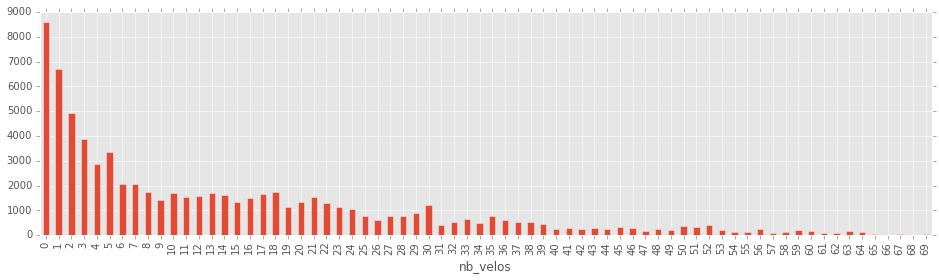

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df.plot(x="nb_velos",y="nb_stations_minutes",kind="bar",figsize=(16,4))

In [ ]:
if os.path.exists("distribution_stands.txt") : os.remove("distribution_stands.txt")
%blob_downmerge /$PSEUDO/velibpy_results/distribution_stands.txt distribution_stands.txt

'distribution_stands.txt'

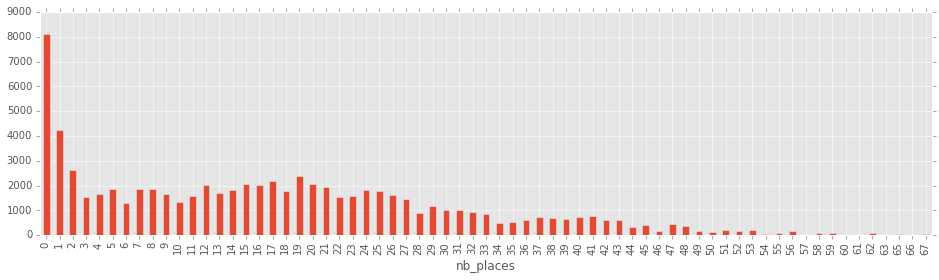

In [ ]:
df = pandas.read_csv("distribution_stands.txt", sep="\t", names=["nb_places", "nb_stations_minutes"])
df.plot(x="nb_places",y="nb_stations_minutes",kind="bar",figsize=(16,4))

In [ ]:
if os.path.exists("fermees.txt") : os.remove("fermees.txt")
%blob_downmerge /$PSEUDO/velibpy_results/fermees.txt fermees.txt

'fermees.txt'

In [ ]:
df = pandas.read_csv("fermees.txt", sep="\t", names=["status", "nb_velos_stations_minutes", "nb_places_stations_minutes"])
df=df.set_index("status")
df = df.T
df["%close"] = df.CLOSED / (df.CLOSED + df.OPEN)
df

status,OPEN,CLOSED,%close
nb_velos_stations_minutes,1066055,3111,0.002910
nb_places_stations_minutes,1276138,122,0.000096


Ce dernier tableau n'est vrai que dans la mesure où les nombres reportées sont fiables lorsque les stations sont fermées.

## Exercice 3 : stations fermées, journée complète
    
Appliquer cela à une journée complète revient à lancer le même job sur des données plus grandes. On verra bientôt commencer éviter de recopier le job une seconde fois (introduisant une source potentielle d'erreur).

## Exercice 4 : astuces

Les erreurs de PIG ne sont pas très explicite surtout si elles se produisent dans le script python. Un moyen simple de débugger est d'attraper les exceptions produites par python et de les récupérer sous PIG (le reste du job est enlevé). On peut tout-à-fait imaginer ajouter la version de python installée sur le cluster ainsi que la liste de modules

In [ ]:
%%PYTHON jython.py

import sys

@outputSchema("brow:chararray")
def information(row):
    return (";".join([str(sys.version), str(sys.executable)])).replace("\n"," ")

On vérifie que le script fonctionne avec jython :

In [ ]:
%%jython jython.py information
n'importe quoi

In [ ]:
%%PIG info.pig

REGISTER '$CONTAINER/$SCRIPTPIG/jython.py' using jython as myfuncs;

jspy = LOAD '$CONTAINER/velib_1h1/*.txt' USING PigStorage('\t') AS (arow:chararray);
one = LIMIT jspy 1 ;
infos  = FOREACH one GENERATE myfuncs.information(arow);
STORE infos INTO '$CONTAINER/$PSEUDO/results/infos' USING PigStorage('\t') ;

In [ ]:
if client.exists(bs, client.account_name, "$PSEUDO/results/infos"):
    r = client.delete_folder (bs, client.account_name, "$PSEUDO/results/infos")
    print(r)

In [ ]:
jid = %hd_pig_submit info.pig jython.py --stop-on-failure
jid

{'id': 'job_1416874839254_0107'}

In [ ]:
st = %hd_job_status jid["id"]
st["id"],st["percentComplete"],st["status"]["jobComplete"]

('job_1416874839254_0107', '100% complete', True)

In [ ]:
%tail_stderr jid["id"] 10

In [ ]:
if os.path.exists("infos.txt") : os.remove("infos.txt")
%blob_downmerge /$PSEUDO/results/infos infos.txt

'infos.txt'

In [ ]:
%head infos.txt